## Read the training data and import library

In [1]:
import numpy as np
import pandas as pd
import pickle

In [2]:
class standardScaler():
    def fit(self, xss):
        self.mean = np.mean(xss, axis=0)
        self.sd = np.std(xss, axis=0)

    def transform(self, xss):
        xss = (xss-self.mean)/(self.sd)
        return(xss)

In [3]:
data = pd.read_csv('data/train.csv', encoding='Big5')
data = data.replace('NR', '0')
data = np.array(data)

## Feature variable 

In [4]:
hour = 9
feature_num = 18
day_per_month = 20
per_month_row = feature_num * day_per_month
total_month = int(len(data)/per_month_row) 

## Process the data 9 hours

In [5]:
month_data = []
for i in range(total_month):
    l = data[i * per_month_row: i * per_month_row  + per_month_row]
    month_data.append(l)  

hour_data = []
for i in range(len(month_data)):
    tmp = []
    for j in range(len(month_data[i])):
        tmp.append(month_data[i][j])
    hour_data.append(tmp)
    
total = []
for i in range(len(hour_data)):
    df = pd.DataFrame(hour_data[i])
    row, col = df.shape
    tmp = None
    for j in range(day_per_month):
        per_day = df.iloc[j*feature_num:j*feature_num+feature_num,:]
        per_day = per_day.iloc[:,3:]
        
        if tmp is not None:
            tmp = pd.concat([tmp.reset_index(drop=True), per_day.reset_index(drop=True)], axis=1, ignore_index=True)
        else:
            tmp = pd.DataFrame(per_day)   
     
    total.append(tmp)

In [35]:
xss = []
yss = []
ori_xss = []
ori_yss = []

for i in range(len(total)):
    df = total[i]
    row, col = df.shape
    for j in range(col-hour-1):
        xs = df.iloc[:,j:j+hour]
        xs = xs.values.ravel()
        ys = float(df.iloc[9,j+hour])
       
        ori_xss.append(xs)
        ori_yss.append(float(ys))
        
        if(ys < 0):
            continue 
        xss.append(xs)
        yss.append(float(ys))
        
xss = pd.DataFrame(xss).values.astype(np.float)
yss = np.array(yss)
ori_xss = pd.DataFrame(ori_xss).values.astype(np.float)
ori_yss = np.array(ori_yss)

## feature scaling
scaler = standardScaler()
scaler.fit(xss)
xss = scaler.transform(xss)
row, col = xss.shape

## Feature Selection

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    
def calculate_vif_(X, thresh=120):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return (X.columns[variables], X[cols[variables]])

X_train = pd.DataFrame(xss)
res = calculate_vif_(X_train)
selected_var , xss = res[0].values, res[1].values

Remaining variables:
Int64Index([  0,   2,   4,   5,   7,   8,   9,  10,  11,  12,
            ...
            152, 153, 154, 155, 156, 157, 158, 159, 160, 161],
           dtype='int64', length=150)


## Select only past pm2.5 as factor

In [37]:
selected_var = np.array([  0,   2,   4,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29, 30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42, 43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77, 78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90, 91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,  156, 157, 158, 159, 160, 161]) 

In [38]:
# selected_var = np.array([(i)*feature_num +9 for i in range(9)])
X_train = pd.DataFrame(xss)
X_train = X_train[selected_var]
xss = X_train.values

## Train the model. Don't forget to remove the clear_output

In [ ]:
from IPython.display import clear_output
max_iter = 10 ** 3
epochs = 10 ** 3
lr = 1

xss = np.column_stack(([1] * len(xss) ,xss))

num = xss.shape[1]
w = np.zeros(num)
w_lr = np.zeros(num)

for t in range(epochs):
    w_grad = None
    for m in range(max_iter):
        predict = np.dot(xss,w)
        w_grad = -(2 * np.dot(xss.T,(yss - predict)))
        w_lr = w_lr + w_grad ** 2
        w = w - lr/np.sqrt(w_lr) * w_grad
        
    clear_output()
    print(t)
    print(np.sqrt(np.mean([ x*x for x in (yss-predict)])))

In [11]:
ori_xss = scaler.transform(ori_xss)
ori_xss = (ori_xss[:,selected_var])
ori_xss = np.column_stack(([1] * len(ori_xss) ,ori_xss))
predict = np.dot(ori_xss,w)
print(np.sqrt(np.mean([ x*x for x in (ori_yss-predict)])))

5.693017905034071


In [63]:
test = pd.read_csv('data/test.csv', encoding='Big5', header=None)
test = test.replace('NR', '0')
file = 'test'

In [64]:
import pickle
dic = {'w': w, 'scaler': scaler, 'selected_var' : selected_var}
with open('model/'+file+'.pkl', 'wb') as f:
    pickle.dump(dic, f)

In [66]:
ans = pd.read_csv('data/sampleSubmission.csv', encoding='Big5')
test_feature = 18
total_test = []
row, col = test.shape
test_number = int(row/test_feature)
print(test_number)
for i in range(test_number):
    df = test.iloc[i*test_feature:(i+1)*test_feature, 2:]
    xs = df.values.ravel().astype(np.float)
    xs = (scaler.transform([xs])[0])
    xs = [xs[i] for i in range(len(xs)) if i in selected_var]
    xs = np.concatenate(([1], xs))
    val = np.dot(xs,w)   
    val = (round(val,2))
    ans.iloc[i,1] = val
ans.to_csv('data/'+file+'.csv',index=False)

240


In [61]:
import matplotlib.pyplot as plt
with open('model/0305-1.pkl', 'rb') as f:
    dic = pickle.load(f)

w = dic['w']
scaler = dic['scaler']
selected_var = dic['selected_var']

71


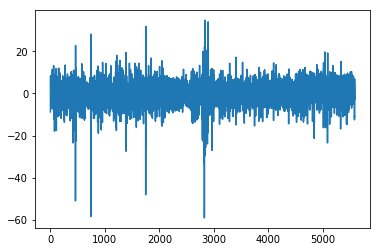

In [39]:
val = np.column_stack(([1] * len(xss) ,xss))
predict = np.dot(val,w)
predict = np.array([max(0,predict[i]) for i in range(len(predict))])

error = (predict-yss)
plt.plot(error)


outlier = [ i for i in range(len(error)) if abs(error[i]) >= 15]


xss = [ xss[i] for i in range(len(xss)) if i not in outlier]
yss = [ yss[i] for i in range(len(yss)) if i not in outlier]
xss = pd.DataFrame(xss)

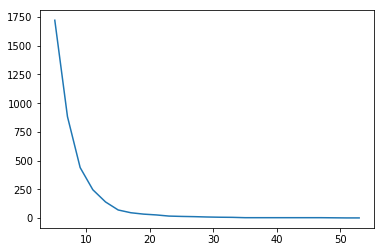

In [47]:
his = []
for j in range(5,55,2):
    l = len([ i for i in range(len(error)) if abs(error[i]) >= j])
    his.append(l)
plt.plot(range(5,55,2),his)

In [437]:
rm = set(range(0,164)) - set(selected_var)
rm = list(rm)
for i in rm:
    print(int(i/18), i % 18)

0 1
9 0
0 3
9 1
0 5
0 6
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
